In [106]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os

In [107]:
# Garantir reprodutibilidade total
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [108]:
df = pd.read_csv('data_per_month.csv')
df = df['Total Renewable Energy']

In [109]:
# Função para criar janelas de dados
def create_windows(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Função para remover outliers
def remove_outliers(X, y, threshold=3):
    mask_X = np.all(np.abs(X - np.mean(X, axis=0)) <= threshold * np.std(X, axis=0), axis=1)
    mask_y = np.abs(y - np.mean(y)) <= threshold * np.std(y)
    mask = mask_X & mask_y
    return X[mask], y[mask]

In [110]:
# Criar janelas de tamanho 12
window_size = 12
X, y = create_windows(df, window_size)

# Remover outliers
X_clean, y_clean = remove_outliers(X, y)

# Dividir em conjuntos de treino, validação e teste
train_size = int(len(X_clean) * 0.7)
val_size = int(len(X_clean) * 0.15)

X_train, y_train = X_clean[:train_size], y_clean[:train_size]
X_val, y_val = X_clean[train_size:train_size + val_size], y_clean[train_size:train_size + val_size]
X_test, y_test = X_clean[train_size + val_size:], y_clean[train_size + val_size:]

# Normalizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [111]:
X_train_scaled.shape[1]

12

Epoch 1/3200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 96528.4375 - mae: 306.8978 - val_loss: 105033.4531 - val_mae: 323.3125
Epoch 2/3200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 95787.6719 - mae: 305.5468 - val_loss: 104344.6328 - val_mae: 322.2506
Epoch 3/3200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 94465.5234 - mae: 303.1346 - val_loss: 102936.7500 - val_mae: 320.0744
Epoch 4/3200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 91763.2266 - mae: 298.1613 - val_loss: 99714.9453 - val_mae: 315.0575
Epoch 5/3200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 86035.6875 - mae: 287.3661 - val_loss: 93014.8828 - val_mae: 304.3318
Epoch 6/3200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 75337.3125 - mae: 265.4772 - val_loss: 81188.2422 - val_mae: 284.2111
Epoch 7/3200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 59535.0469 - mae: 227.6352 - val_loss: 64395.6680 - val_mae: 252.0922
Epoch 8/3200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 42451.4805 - mae: 189.4713 

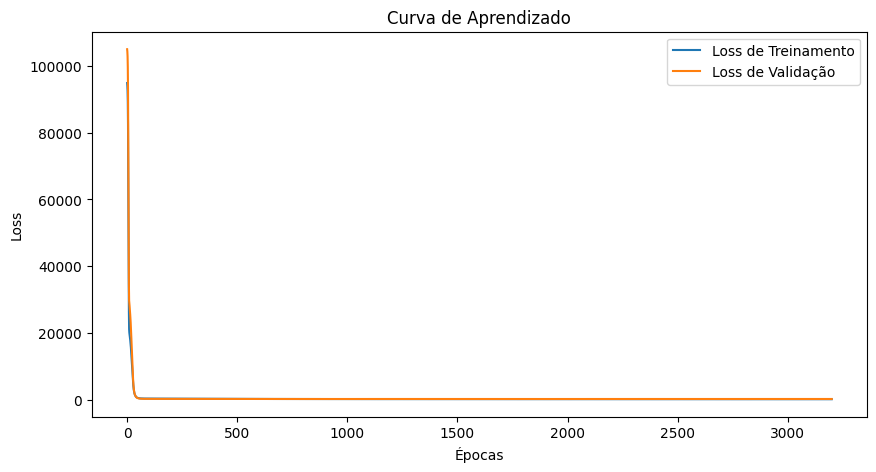

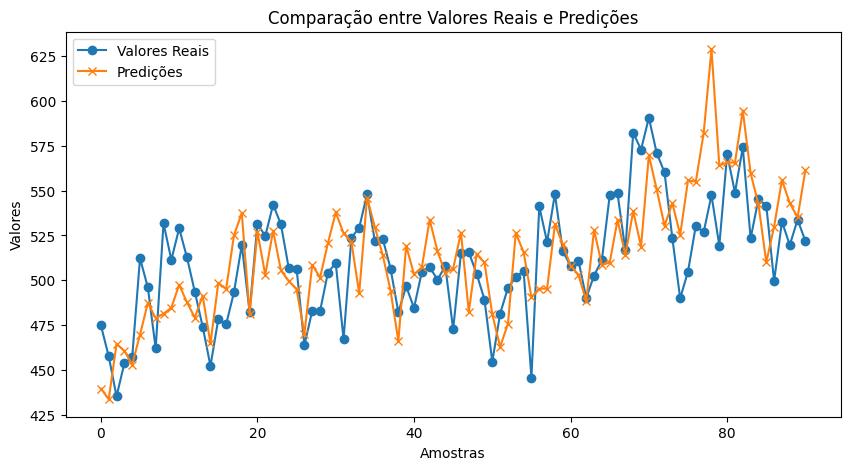

In [112]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Função para criar o modelo com regularização
def create_model(neurons=24, dropout_rate=0.2, optimizer='adam'):
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(neurons, activation='relu'),
        # Dropout(dropout_rate),
        Dense(neurons, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1)
    ])
    
    optimizer_instance = Adam() if optimizer == 'adam' else RMSprop()
    model.compile(optimizer=optimizer_instance, loss='mse', metrics=['mae'])
    return model

# Definir manualmente os hiperparâmetros
# dropout_rate = 0.2
optimizer = 'adam'
batch_size = 16
epochs = 3200

# Criar e treinar o modelo
model = create_model(optimizer=optimizer)
history = model.fit(X_train_scaled, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2)

# Fazer previsões
y_pred = model.predict(X_test_scaled)

# Calcular métricas
eval_results = model.evaluate(X_test_scaled, y_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Loss: {eval_results[0]}, MAE: {eval_results[1]}")
print(f"R²: {r2}, RMSE: {rmse}")

# Plot da curva de aprendizado
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Loss de Treinamento')
plt.plot(history.history['val_loss'], label='Loss de Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.title('Curva de Aprendizado')
plt.show()

# Comparação entre valores reais e previstos
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Valores Reais', marker='o')
plt.plot(y_pred, label='Predições', marker='x')
plt.xlabel('Amostras')
plt.ylabel('Valores')
plt.legend()
plt.title('Comparação entre Valores Reais e Predições')
plt.show()
